In [10]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel, AutoConfig
from torch.utils.data import Dataset, DataLoader

In [2]:
def split(X, y, seed, z=None, train_size=0.7, test_size=0.3, val_size=0.2):
    X_val = None
    y_val = None
    Z_train, Z_val, Z_test = None, None, None
    if train_size is None and test_size is None:
        raise AttributeError()
    elif train_size is None:
        train_size = 1. - test_size
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed, shuffle=True,
                                                        train_size=train_size)
    if z is not None:
        Z_train, Z_test = train_test_split(z, stratify=y, random_state=seed, shuffle=True, train_size=train_size)
    if val_size is not None:
        if z is not None:
            Z_train, Z_val = train_test_split(Z_train, stratify=y_train, random_state=seed, shuffle=True,
                                              test_size=val_size)

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=seed,
                                                          shuffle=True, test_size=val_size)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (Z_train, Z_val, Z_test)



In [3]:
def get_dataset(
        df: str | pd.DataFrame = 'dataset/EDOS_1M_balanced.pkl',
        seed=0
):
    df = df
    if isinstance(df, str):
        if df.endswith('pkl'):
            df = pd.read_pickle(df)
        else:
            df = pd.read_csv(df)
    groups = []
    labels = []
    confidence = []
    for name, group in df.groupby(by='eb+_emot'):
        group = group.reset_index(drop=True)
        groups.append(group.loc[:, 'uttr'])
        confidence.append(group.loc[:, 'label_confidence'])
        labels.append(group.loc[:, 'eb+_emot'])

    groups = np.array(groups, dtype=str)
    labels = np.array(labels, dtype=str)

    confidence = np.array(confidence, dtype=np.float32)
    return groups, labels, confidence


In [4]:
groups, labels, confidence = get_dataset()

In [6]:
unique = np.unique(labels.flatten())
emotions_to_category = {key: value for key, value in zip(unique, range(len(unique)))}
category_to_emotion = {key: value for key, value in zip(range(len(unique)), unique)}

seed = 0
(X_train, y_train), (X_val, y_val), (X_test, y_test), (Z_train, Z_val, Z_test) = split(groups.flatten(),
                                                                                       labels.flatten(), seed,
                                                                                       confidence.flatten())


In [7]:
X_train

array(["Tom 's okay . I guess he 's a little stuffy , but I think it 's from living with Paul so long .",
       'Joy .',
       "Baby 's sleeping . Oh , bless her little heart . Let 's go .",
       ..., 'Cleaning . Cooking a little bit .',
       'I would be honored . I pledge allegiance to the flag of the United States of America and to the republic for which it stands , one nation , under God , individis ... in the windowsill ... with liberty and justice for all .',
       "Don 't worry . I think it will be solved ."], dtype='<U532')

In [8]:
y_train

array(['content', 'joyful', 'grateful', ..., 'prepared', 'faithful',
       'encouraging'], dtype='<U13')

In [9]:
df_train = pd.DataFrame({'X_train': X_train, 'y_train': y_train})
df_train.head(5)

,X_train,y_train
0,"Tom 's okay . I guess he 's a little stuffy , ...",content
1,Joy .,joyful
2,"Baby 's sleeping . Oh , bless her little heart...",grateful
3,Can we leave the lit lights ?,suggesting
4,"Sajani , you have truly taken such good care o...",grateful


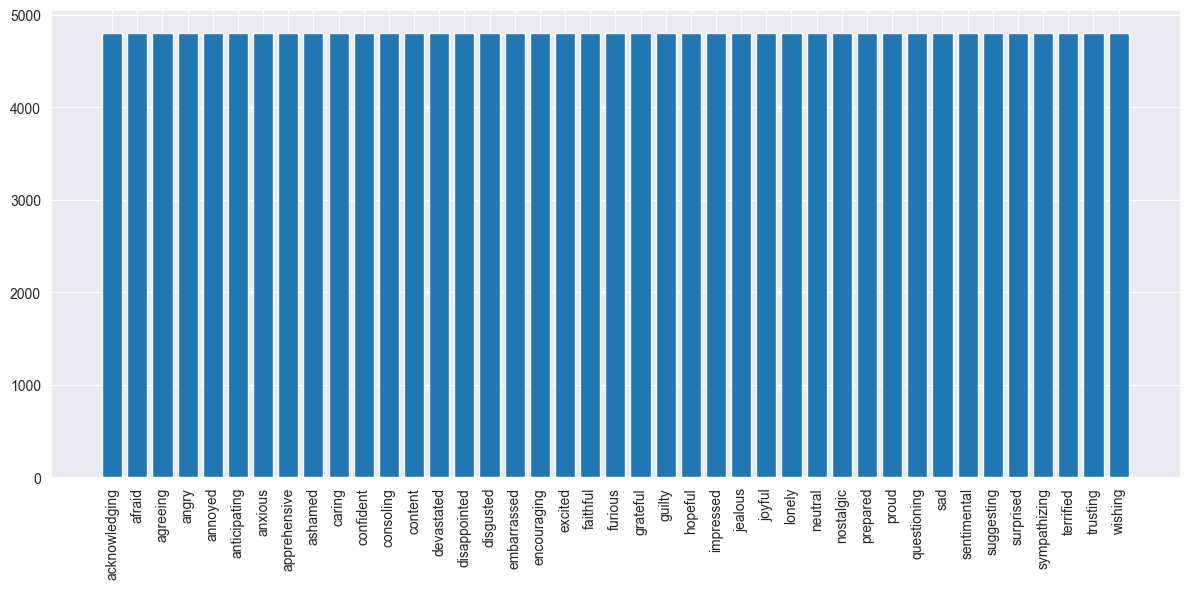

In [15]:
fig = plt.figure(figsize=(12,6))
emotion_list, emotion_count = np.unique(y_train, return_counts=True)
plt.bar(emotion_list, emotion_count)
plt.xticks(np.arange(0, len(emotion_list)), emotion_list, rotation=90)
plt.tight_layout()
plt.show()

In [40]:
# ZERO SHOT
from transformers import pipeline
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
pipe = pipeline('zero-shot-classification', model='cross-encoder/nli-distilroberta-base', device=DEVICE)


In [41]:
df_test = pd.DataFrame({'X_test': X_train, 'y_test': y_train})
df_test = df_test.groupby('y_test').head(100)
df_test.shape

(4100, 2)

In [46]:
X_test_to_feed = df_test.loc[:, 'X_test'].to_numpy().tolist()
true_labels = df_test.loc[:, 'y_test'].to_numpy().tolist()
X_test_to_feed

["Tom 's okay . I guess he 's a little stuffy , but I think it 's from living with Paul so long .",
 'Joy .',
 "Baby 's sleeping . Oh , bless her little heart . Let 's go .",
 'Can we leave the lit lights ?',
 'Sajani , you have truly taken such good care of the house in my absence .',
 "Okay , Kuol , I 'm actually working ... Prepare yourself for a shock . Okay . Look ! That 's amazing . As I said it was . That 's over 150 grand . This is the break we 've needed . Pam , come here . The article mentioned the Web site , and like mag , the money appeared . Look at that ! Congratulations , Kuol !",
 "She didn 't even ask for an attorney . Just walked right into his office and said she wanted to confess everything . Guess she figured it was just a matter of time before we could prove that she tampered with the DNA evidence .",
 'The Old Train',
 'The ruins are in elevation . Only the darkness can see your soul .',
 "I forgot to close it , sorry Something got in No Something got in , in the

In [48]:
print_seq = True
out_labels = []
top_5 = []
for i in range(len(X_test_to_feed)):
    if i > 10:
        print_seq = False
    s = pipe(X_test_to_feed[i], candidate_labels=emotion_list)
    t = true_labels[i]
    if print_seq:
        print(f'SEQUENCE {i}: ', s['sequence'])
        print(f'TRUE LABEL:', t)
    labels = np.array(s['labels'])
    probs = np.array(s['scores'])
    index = np.argsort(probs)[-5:][::-1]
    out_labels.append(labels[probs.argmax()])
  
    top_5.append(t in labels[index])
    if print_seq:
        print(f'TOP 5: {labels[index]} with probs: {probs[index]}\n\n')

SEQUENCE 0:  Tom 's okay . I guess he 's a little stuffy , but I think it 's from living with Paul so long .
TRUE LABEL: content
TOP 5: ['questioning' 'suggesting' 'nostalgic' 'acknowledging' 'sentimental'] with probs: [0.14372656 0.08854562 0.06942335 0.0636989  0.06273227]

SEQUENCE 1:  Joy .
TRUE LABEL: joyful
TOP 5: ['grateful' 'caring' 'excited' 'acknowledging' 'hopeful'] with probs: [0.08769108 0.08526675 0.08008437 0.07491972 0.06398449]

SEQUENCE 2:  Baby 's sleeping . Oh , bless her little heart . Let 's go .
TRUE LABEL: grateful
TOP 5: ['grateful' 'caring' 'acknowledging' 'prepared' 'suggesting'] with probs: [0.11391021 0.09846934 0.08615367 0.06697151 0.05587219]

SEQUENCE 3:  Can we leave the lit lights ?
TRUE LABEL: suggesting
TOP 5: ['questioning' 'suggesting' 'surprised' 'caring' 'nostalgic'] with probs: [0.56655818 0.09833935 0.03413756 0.0281138  0.02413677]

SEQUENCE 4:  Sajani , you have truly taken such good care of the house in my absence .
TRUE LABEL: grateful
TOP

KeyboardInterrupt: 